In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.layers import concatenate, Dense, BatchNormalization, Activation, Lambda
from keras.models import Model
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data Preparation

In [3]:
train_dict, train_files = data.get_data('train')

preprocess False
keypoints None
0.837369918823


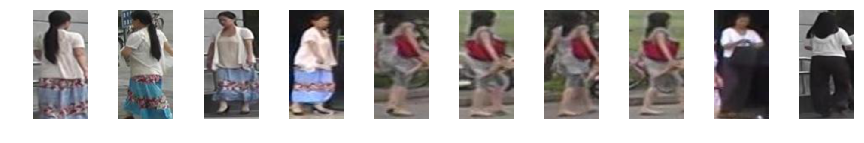

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=5, K=4, preprocess=False,
                                    shape=(256,128), keypoints=None, r=0.5).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

# import cv2
# plt.figure(figsize=(15,2))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.imshow(cv2.resize((255 * batch[0]['input_cam'][i]).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
#     plt.axis('off')
# plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [6]:
file_root = 'cam_merge_all'
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

# step_decay_cont_str = """
# def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
#     drop = 0.5
#     epochs_drop = 10.0
#     t1 = 50.0
#     if epoch + init_epoch < t1:
#         lrate = init_lr
#     else:
#         lrate = init_lr * np.power(drop,  
#                np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
#     return lrate
# """

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0001):
    drop = 0.5
    epochs_drop = 10.0
    lrate = init_lr * np.power(drop, (epoch + init_epoch)/(epochs_drop))
    return lrate
"""

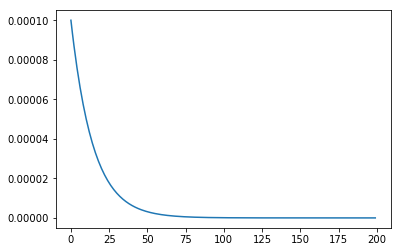

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 18
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=0.5, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 512)

exec(def_triplet_loss)

In [10]:
TF_ROOT = '/home/albert/github/tensorflow/models/'
json_file = '/home/albert/github/tensorflow/models/densenet_triplet/densenet_triplet.json'

# base_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet/densenet_triplet_13000.npy')
# front_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_front/densenet_triplet_front_10000.npy')
# back_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/pre2/models/densenet_triplet_back_3/densenet_triplet_back_3_10000.npy')

# front_model = dense.DenseNetImageNet121(input_shape=(input_shape[0], input_shape[1], 3), weights='imagenet', cam_placement=[0])
# back_model = dense.DenseNetImageNet121(input_shape=(input_shape[0], input_shape[1], 3), weights='imagenet', cam_placement=[0])

# from keras.models import load_model

base_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/densenet_triplet/densenet_triplet_13000.npy')
neck_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/neck_cam_inverse_aws/neck_cam_inverse_aws_10000.npy')
hip_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/hip_cam_inverse_aws/hip_cam_inverse_aws_7000.npy')
ankle_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/ankle_cam_inverse_aws/ankle_cam_inverse_aws_8000.npy')

# front_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/densenet_triplet_front_2/densenet_triplet_front_2_10000.npy')
# back_model = evaluation.load_model(json_file, '/home/albert/github/tensorflow/models/densenet_triplet_back_2/densenet_triplet_back_2_10000.npy')

In [11]:
# np.mean(base_model.predict(100 * np.ones((1,256,128,3))))
# np.mean(base_model.predict(densenet.preprocess_input(batch[0]['input_im'][6]).reshape(1,256,128,3)))

In [12]:
for layer in base_model.layers:
    layer.name = layer.name + '_b'
for layer in neck_model.layers:
    layer.name = layer.name + '_n'
for layer in hip_model.layers:
    layer.name = layer.name + '_h'
for layer in ankle_model.layers:
    layer.name = layer.name + '_a'

In [13]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im_b (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1_b (Conv2D)              (None, 128, 64, 64)   9408        input_im_b[0][0]                 
____________________________________________________________________________________________________
batch_normalization_1_b (BatchNo (None, 128, 64, 64)   256         conv2d_1_b[0][0]                 
____________________________________________________________________________________________________
activation_1_b (Activation)      (None, 128, 64, 64)   0           batch_normalization_1_b[0][0]    
___________________________________________________________________________________________

In [14]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in neck_model.layers[:-4]:
    layer.trainable = False
for layer in hip_model.layers[:-4]:
    layer.trainable = False
for layer in ankle_model.layers[:-4]:
    layer.trainable = False

In [15]:
base_model.layers[311].trainable

False

In [16]:
base_model.layers[311]

In [17]:
# x = concatenate([base_model.output, front_model.output])
# x = Dense(1024)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# predictions = Dense(128, name='final_output')(x)

predictions = concatenate([base_model.output, neck_model.output, hip_model.output, ankle_model.output], name='final_output')

In [18]:
model = Model(inputs=[base_model.input, neck_model.input, hip_model.input,ankle_model.input], outputs=predictions)
# model = Model(inputs=[base_model.input, front_model.input[0], front_model.input[1], 
#                       back_model.input[0], back_model.input[1]], outputs=predictions)
model.compile(loss=triplet_loss, 
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im_b (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_n (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_h (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_a (InputLayer)          (None, 256, 128, 3)   0                                            
___________________________________________________________________________________________

batch_normalization_71_h (BatchN (None, 16, 8, 128)    512         conv2d_70_h[0][0]                
____________________________________________________________________________________________________
batch_normalization_71_a (BatchN (None, 16, 8, 128)    512         conv2d_70_a[0][0]                
____________________________________________________________________________________________________
activation_71_b (Activation)     (None, 16, 8, 128)    0           batch_normalization_71_b[0][0]   
____________________________________________________________________________________________________
activation_71_n (Activation)     (None, 16, 8, 128)    0           batch_normalization_71_n[0][0]   
____________________________________________________________________________________________________
activation_71_h (Activation)     (None, 16, 8, 128)    0           batch_normalization_71_h[0][0]   
___________________________________________________________________________________________

In [20]:
model.output

<tf.Tensor 'final_output_4/concat:0' shape=(?, 512) dtype=float32>

In [23]:
model_json = model.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [22]:
score = {}
history = History()

for era in range(1,11):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(data.output_batch_generator(train_dict, model=model, P=P_param, K=K_param, 
                                                    preprocess=True, keypoints=None,
                                                    shape=(256,128)), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), model.get_weights())
    
    score[iterations] = evaluation.get_score(model,
                                                   hist=history, preprocess=preprocess, 
                                                   shape=input_shape)
    print iterations, score[iterations]

preprocess True
keypoints None
Epoch 1/10
100/100 [==============================] - 414s - loss: 8.1215   
Epoch 2/10
100/100 [==============================] - 408s - loss: 7.1900   
Epoch 3/10
100/100 [==============================] - 406s - loss: 2.8964   
Epoch 4/10
100/100 [==============================] - 405s - loss: 5.0160   
Epoch 5/10
100/100 [==============================] - 404s - loss: 3.7363   
Epoch 6/10
100/100 [==============================] - 402s - loss: 4.4947   
Epoch 7/10
100/100 [==============================] - 401s - loss: 3.7762   
Epoch 8/10
100/100 [==============================] - 395s - loss: 2.2455   
Epoch 9/10
100/100 [==============================] - 395s - loss: 4.9608   
Epoch 10/10
100/100 [==============================] - 394s - loss: 1.9537   
1000 79.9090919495
2000 157.95147109
3000 235.997472048
4000 313.99849987
5000 392.209218979
6000 470.486938953
7000 548.81901598
8000 627.098013878
9000 705.205713987
10000 783.195168972
11000 861.

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.309673). Check your callbacks.
  % delta_t_median)


 85/100 [========================>.....] - ETA: 60s - loss: 2.1440

KeyboardInterrupt: 

In [ ]:
# np.save('/home/albert/merge_base_neck_hip_3000.npy', model.get_weights())

In [ ]:
# file_name = file_root + '_' + str(1000) + '.npy'
# np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), model.get_weights())

In [ ]:
# score[1000] = evaluation.get_score(model,
#                                                    hist=history, preprocess=preprocess, 
#                                                    shape=input_shape)
# print score

In [ ]:
# np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), score)

### Evaluation